My analysis script for my internship report for the Research Experience module at master's degree program in cognitive neuroscience at Freie Universität Berlin.

I conducted my internship at Center for Adaptive Rationality at Max Planck Institute for Human Development. My supervisor was Dr. Philipp Lorenz-Spreen.

Data is not available because of data sharing restrictions.

contact: <ekin.derdiyok {at} fu-berlin.de>

# Import necessary packages

In [1]:
pip install pingouin

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy.stats
import pingouin as pg
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from datetime import datetime


# Check if the import is succesful and for documentation

In [3]:
print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(sklearn.__version__)
print(scipy.__version__)
print(pg.__version__)

1.4.4
1.21.5
3.5.2
0.11.2
1.1.1
1.9.1
0.5.3


# Load the data

In [4]:
data = pd.read_csv("/Users/ekinderdiyok/Documents/MPI/Twitter/public_dataset.csv", low_memory = False)

# Subset the data to exclude tweets with 0 favs or RTs

In [5]:
data["engagement"] = data.favorite_count + data.retweet_count # Create a new variable 
(data.engagement == 0).sum() # count the number of tweets with 0 engagement

data = data.loc[data.engagement>0,:] # do the subsetting

# Distribution of sentiment in the data
* Very rough way to look at the sentiments in the data. Simply summing up the sentiment scores that are the number of occurences of sentimental words across all tweets.

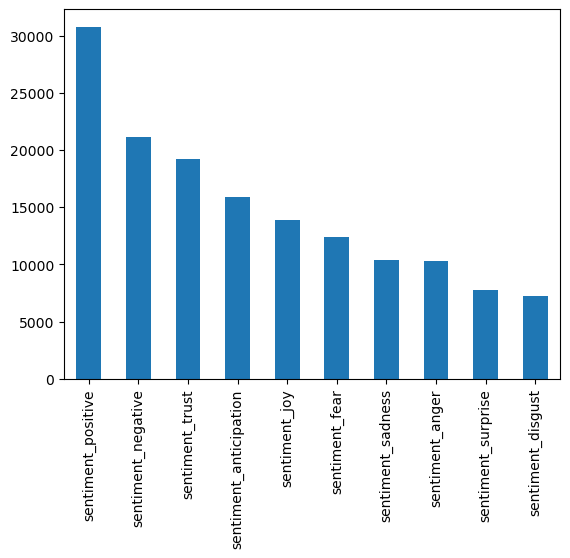

In [6]:
_=data.loc[:,"sentiment_anger":"sentiment_positive"].sum().sort_values(ascending=False).plot(kind="bar") # Draws a barplot

# Distribution of sentiment in the data
* Very rough way to look at the motives in the data. Simply summing up the motive scores that are the self-reported in a 6-point likert scale

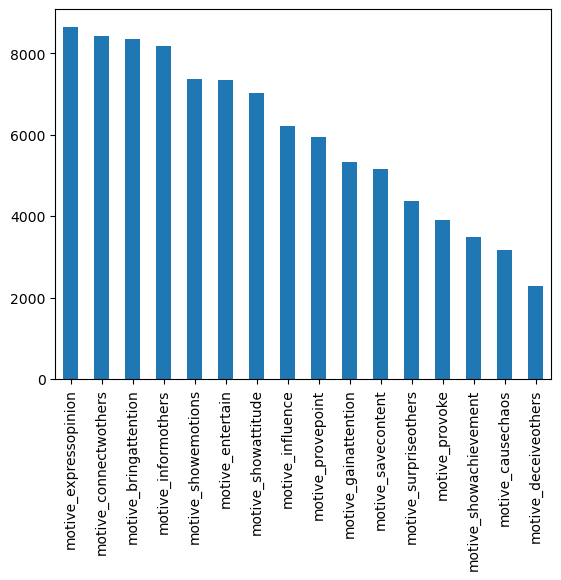

In [7]:
_=data.loc[:,"motive_entertain":"motive_informothers"].sum().sort_values(ascending=False).plot(kind="bar")

# Distribution of engagement percentage
* Exploring the engagement percentage to better understand the data, not part of the report.
* Engagement percentage is defined as (retweet count + favorite count)/follower count of the sender * 100

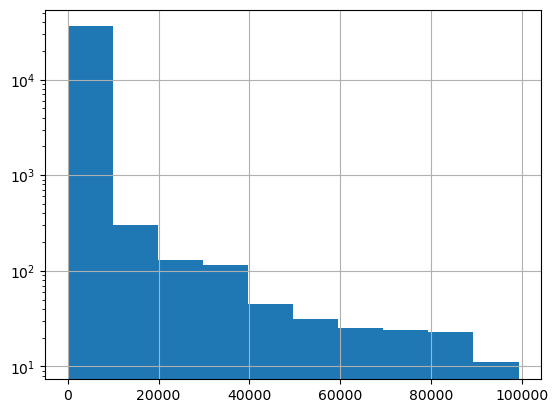

In [8]:
data["pct_eng"] = data.engagement / data.followers_count * 100
data.loc[data["pct_eng"] > 100000,"pct_eng"] = np.nan
data["pct_eng"].hist()
plt.yscale("log")
#plt.ylim(0,1000)

# Correlation between sentiments and motives
* One important finding was to add tweet length as a covariate which reduces down the inflated correlation between sentiments. Since dictionary methods counts the occurence of words, and longer tweets tend to have more words some of which are sentimental, correlation among sentiments were inflated.
* Due to space restrictions and not being directly related to other analysis,is not present in the report.
* Adding text width as covariance reduces the correlation between sentiment_positive and sentiment_negative

In [9]:
data["mood"] = data.sentiment_positive - data.sentiment_negative # Create a new column that nullifies the tweets with equal amount of positive and negative words
sents_mots = [['sentiment_anger', 'sentiment_disgust', 'sentiment_fear', # Create a list of cols for correlation table
       'sentiment_anticipation', 'sentiment_joy', 'sentiment_sadness',
       'sentiment_surprise', 'sentiment_trust', 'sentiment_negative',
       'sentiment_positive',"mood"],['motive_provoke', 'motive_savecontent', 'motive_showemotions',
       'motive_connectwothers', 'motive_showachievement',
       'motive_showattitude', 'motive_deceiveothers', 'motive_gainattention',
       'motive_provepoint', 'motive_causechaos', 'motive_bringattention',
       'motive_influence', 'motive_surpriseothers', 'motive_informothers']]

corr = pg.pairwise_corr(data=data, columns=sents_mots) # sentiment_positive and sentiment_negative are correlated, so add display_text_width as covariance
sig_corr_table = corr[corr["p-unc"]<0.001] # Filter for p < .001
sig_corr_table["abs_r"] = abs(sig_corr_table.r) # Create abs value column for r
display(sig_corr_table.sort_values(by="abs_r",ascending=False)) # sort by abs_r so that biggest r values are on top
display(sig_corr_table[sig_corr_table.X.isin(["mood","sentiment_negative","sentiment_positive"])])
display(pg.pairwise_corr(data=data, columns=["sentiment_positive","sentiment_negative"], covar="display_text_width"))

/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_5046/3829393135.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_corr_table["abs_r"] = abs(sig_corr_table.r) # Create abs value column for r


,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power,abs_r
123,sentiment_negative,motive_influence,pearson,two-sided,2067,0.255862,"[0.22, 0.3]",2.973387e-32,5.905e+28,1.000000,0.255862
137,sentiment_positive,motive_influence,pearson,two-sided,2067,0.245307,"[0.2, 0.29]",1.052462e-29,1.749e+26,1.000000,0.245307
120,sentiment_negative,motive_provepoint,pearson,two-sided,2067,0.237646,"[0.2, 0.28]",6.276360e-28,3.037e+24,1.000000,0.237646
106,sentiment_trust,motive_provepoint,pearson,two-sided,2067,0.223792,"[0.18, 0.26]",7.099928e-25,2.867e+21,1.000000,0.223792
109,sentiment_trust,motive_influence,pearson,two-sided,2067,0.218557,"[0.18, 0.26]",8.975849e-24,2.327e+20,1.000000,0.218557
134,sentiment_positive,motive_provepoint,pearson,two-sided,2067,0.217956,"[0.18, 0.26]",1.196109e-23,1.752e+20,1.000000,0.217956
139,sentiment_positive,motive_informothers,pearson,two-sided,2067,0.215131,"[0.17, 0.26]",4.559123e-23,4.66e+19,1.000000,0.215131
125,sentiment_negative,motive_informothers,pearson,two-sided,2067,0.210551,"[0.17, 0.25]",3.835241e-22,5.67e+18,1.000000,0.210551
111,sentiment_trust,motive_informothers,pearson,two-sided,2067,0.207461,"[0.17, 0.25]",1.569421e-21,1.408e+18,1.000000,0.207461
81,sentiment_sadness,motive_influence,pearson,two-sided,2067,0.194895,"[0.15, 0.24]",3.847643e-19,6.135e+15,1.000000,0.194895


,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power,abs_r
112,sentiment_negative,motive_provoke,pearson,two-sided,2067,0.086348,"[0.04, 0.13]",8.469887e-05,62.075,0.975786,0.086348
113,sentiment_negative,motive_savecontent,pearson,two-sided,2067,-0.129692,"[-0.17, -0.09]",3.262940e-09,1.095e+06,0.999964,0.129692
114,sentiment_negative,motive_showemotions,pearson,two-sided,2067,0.080443,"[0.04, 0.12]",2.512412e-04,22.316,0.955752,0.080443
117,sentiment_negative,motive_showattitude,pearson,two-sided,2067,0.136589,"[0.09, 0.18]",4.505449e-10,7.534e+06,0.999991,0.136589
120,sentiment_negative,motive_provepoint,pearson,two-sided,2067,0.237646,"[0.2, 0.28]",6.276360e-28,3.037e+24,1.000000,0.237646
122,sentiment_negative,motive_bringattention,pearson,two-sided,2067,0.177639,"[0.14, 0.22]",4.081505e-16,6.372e+12,1.000000,0.177639
123,sentiment_negative,motive_influence,pearson,two-sided,2067,0.255862,"[0.22, 0.3]",2.973387e-32,5.905e+28,1.000000,0.255862
125,sentiment_negative,motive_informothers,pearson,two-sided,2067,0.210551,"[0.17, 0.25]",3.835241e-22,5.67e+18,1.000000,0.210551
127,sentiment_positive,motive_savecontent,pearson,two-sided,2067,-0.097687,"[-0.14, -0.05]",8.618136e-06,544.226,0.993672,0.097687
128,sentiment_positive,motive_showemotions,pearson,two-sided,2067,0.106999,"[0.06, 0.15]",1.084162e-06,3969.587,0.998255,0.106999


,X,Y,method,covar,alternative,n,r,CI95%,p-unc
0,sentiment_positive,sentiment_negative,pearson,['display_text_width'],two-sided,36699,0.082006,"[0.07, 0.09]",8.616137e-56


# Create new variable categorical variable `dom_mot` 
* that is the highest motive of that tweet.
* this variable was created in order to predict the dominant motive of a tweet using other information about that tweet. This was then abandoned since I failed to successfully program this analysis.
* the participant has to rate their motive above average (4,5,6 but not 1,2,3). Otherwise it is assigned NaN, hence no dominant motive.
* Analysis using `dom_mot` did not make it to the report

In [7]:
# create a variable that holds the names of mot variables
mots = ['motive_entertain', 'motive_expressopinion', 'motive_provoke', 'motive_savecontent', 'motive_showemotions', 'motive_connectwothers', 'motive_showachievement', 'motive_showattitude', 'motive_deceiveothers', 'motive_gainattention', 'motive_provepoint', 'motive_causechaos', 'motive_bringattention', 'motive_influence', 'motive_surpriseothers', 'motive_informothers'] 

# create a variable that holds the names of sent variables
sents =  ['sentiment_anger', 'sentiment_disgust', 'sentiment_fear',      'sentiment_anticipation', 'sentiment_joy', 'sentiment_sadness','sentiment_surprise', 'sentiment_trust', 'sentiment_negative','sentiment_positive']

data["dom_mot"] = data[mots].idxmax(axis=1).str[7:] # name of the motive with the highest score
data.loc[data[mots].max(axis=1) < 4, "dom_mot"] = np.nan # assign NaN to dom_mot whenever a tweet has less than 4 for the max motive.
print(data.dom_mot.value_counts())

expressopinion     1013
entertain           904
connectwothers      158
bringattention      139
showemotions        116
savecontent         103
informothers         95
provepoint           51
showachievement      24
showattitude         21
provoke              19
gainattention        14
surpriseothers        5
causechaos            4
influence             2
deceiveothers         1
Name: dom_mot, dtype: int64


# Investigating whether tweets of different sentiments receive higher engagement

positive        3729
negative        2152
anticipation    1554
trust           1502
fear             853
anger            690
joy              583
sadness          318
disgust          204
surprise         165
Name: dom_sent, dtype: int64


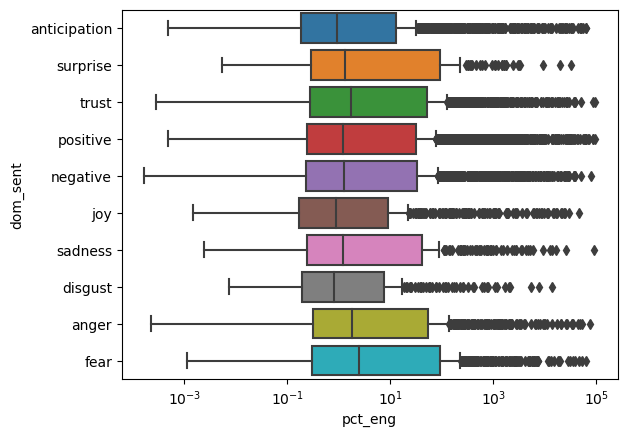

In [11]:
data["dom_sent"] = data[sents].idxmax(axis=1).str[10:] # name of the sentiment with highest percentage
data.loc[data[sents].max(axis=1) < 2, "dom_sent"] = np.nan # assign NaN to dom_mot whenever a tweet has less than 4 for the max motive.
print(data.dom_sent.value_counts())
sns.boxplot(data=data,x="pct_eng",y="dom_sent")
plt.xscale("log")

# Engagement percentage and popularity of a tweet by negative vs positive
* t-test and Mann-Whitney U test comparing positive and negative tweets with regards to their popularity
* MWU is reported in the internship report.

In [12]:
feats = ["pct_eng","favorite_count","retweet_count"]
pd.options.display.max_columns = None
display(data.groupby("dom_sent")[feats].describe().loc[["negative","positive"],:])

print("two sample independent t-test between for engagement percentage between  positive and negative tweets ")
display(pg.ttest(x=data.loc[data.dom_sent == "positive","pct_eng"],y=data.loc[data.dom_sent == "negative","pct_eng"]))

print("two sample independent t-test between for favorite count between  positive and negative tweets ")
display(pg.ttest(x=data.loc[data.dom_sent == "positive","favorite_count"],y=data.loc[data.dom_sent == "negative","favorite_count"]))

print("two sample independent t-test between for retweet count between  positive and negative tweets ")
display(pg.ttest(x=data.loc[data.dom_sent == "positive","retweet_count"],y=data.loc[data.dom_sent == "negative","retweet_count"]))

print("two sample independent mwu-test between for engagement percentage between  positive and negative tweets ")
display(pg.mwu(x=data.loc[data.dom_sent == "positive","pct_eng"],y=data.loc[data.dom_sent == "negative","pct_eng"]))

print("two sample independent mwu-test between for favorite count between  positive and negative tweets ")
display(pg.mwu(x=data.loc[data.dom_sent == "positive","favorite_count"],y=data.loc[data.dom_sent == "negative","favorite_count"]))

print("two sample independent mwu-test between for retweet count between  positive and negative tweets ")
display(pg.mwu(x=data.loc[data.dom_sent == "positive","retweet_count"],y=data.loc[data.dom_sent == "negative","retweet_count"]))



pct_eng                                                         \
           count        mean          std       min       25%       50%   
dom_sent                                                                  
negative  2143.0  625.878490  3656.883288  0.000166  0.230947  1.236749   
positive  3722.0  684.941683  4807.033569  0.000478  0.240243  1.204819   

                                  favorite_count                               \
                75%           max          count       mean          std  min   
dom_sent                                                                        
negative  33.222334  80062.500000         2152.0  14.693773   129.023874  0.0   
positive  31.095437  95789.285714         3729.0  41.038080  1266.572017  0.0   

                                 retweet_count                                 \
          25%  50%  75%      max         count         mean          std  min   
dom_sent                                                                        
negative  0.0  0.0  2.0   2629.0        2152.0  2560.990242  11599.58909  0.0   
positive  0.0  0.0  2.0  75779.0        3729.0  1934.691606  11151.62035  0.0   

                                      
          25%  50%     75%       max  
dom_sent                              
negative  0.0  5.0  371.25  323367.0  
positive  0.0  3.0  232.00  427493.0

two sample independent t-test between for engagement percentage between  positive and negative tweets 


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.529367,5430.23175,two-sided,0.596573,"[-159.67, 277.79]",0.013358,0.035,0.078222


two sample independent t-test between for favorite count between  positive and negative tweets 


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.258876,3861.113133,two-sided,0.208151,"[-14.68, 67.37]",0.026042,0.067,0.160846


two sample independent t-test between for retweet count between  positive and negative tweets 


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.022714,4344.432781,two-sided,0.043164,"[-1233.34, -19.26]",0.055339,0.234,0.533457


two sample independent mwu-test between for engagement percentage between  positive and negative tweets 


,U-val,alternative,p-val,RBC,CLES
MWU,3956053.0,two-sided,0.60754,0.008041,0.495979


two sample independent mwu-test between for favorite count between  positive and negative tweets 


,U-val,alternative,p-val,RBC,CLES
MWU,4010728.0,two-sided,0.97692,0.000418,0.499791


two sample independent mwu-test between for retweet count between  positive and negative tweets 


,U-val,alternative,p-val,RBC,CLES
MWU,3860395.0,two-sided,0.01233,0.037885,0.481058


# How does the sentiment of the tweet differ between different tweet types
* Amount of sentiment_positive words retweet > original > (reply > quote)
* Amount of sentiment_negative words retweet > original > (quote > reply)
* The conclusion is that retweets tend to contain more sentimental words.

In [13]:
# Create tweet_type variable
for index, row in data.iterrows():
    if data.loc[index, "is_retweet"] == True:
        data.loc[index, "tweet_type"] = "retweet"
    elif (data.loc[index, "is_reply"] == True) & (data.loc[index, "is_quote"] == True):
        data.loc[index, "tweet_type"] = "quote_reply"
    elif (data.loc[index, "is_reply"] == False) & (data.loc[index, "is_quote"] == True): 
        data.loc[index, "tweet_type"] = "quote"
    elif (data.loc[index, "is_reply"] == True) & (data.loc[index, "is_quote"] == False):
        data.loc[index, "tweet_type"] = "reply"
    elif (data.loc[index, "is_reply"] == False) & (data.loc[index, "is_quote"] == False) & (data.loc[index, "is_retweet"] == False):
        data.loc[index, "tweet_type"] = "original"

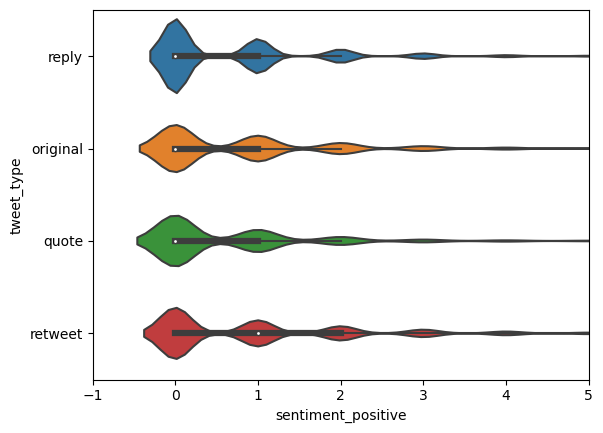

,count,mean,std,min,25%,50%,75%,max
tweet_type,,,,,,,,
original,4135.0,0.837969,1.136695,0.0,0.0,0.0,1.0,8.0
quote,1611.0,0.648045,1.006020,0.0,0.0,0.0,1.0,9.0
reply,15198.0,0.704698,1.037581,0.0,0.0,0.0,1.0,10.0
retweet,15549.0,0.993183,1.298940,0.0,0.0,1.0,2.0,9.0


,W,pval,equal_var
levene,206.913022,4.338515e-133,False


,Source,ddof1,ddof2,F,p-unc,np2
0,tweet_type,3,6343.770795,169.961305,5.553532e-106,0.013975


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,original,quote,0.8380,0.6480,0.1899,0.0307,6.1923,3292.6509,0.0000,0.1724
1,original,reply,0.8380,0.7047,0.1333,0.0196,6.8071,6135.0122,0.0000,0.1258
2,original,retweet,0.8380,0.9932,-0.1552,0.0205,-7.5648,7270.6111,0.0000,-0.1225
3,quote,reply,0.6480,0.7047,-0.0567,0.0264,-2.1427,1990.8623,0.1401,-0.0548
4,quote,retweet,0.6480,0.9932,-0.3451,0.0271,-12.7156,2207.3923,0.0000,-0.2708
5,reply,retweet,0.7047,0.9932,-0.2885,0.0134,-21.5414,29577.6634,0.0000,-0.2451


In [14]:
# Visualize the distribution, do ANOVA. test for equality of variance, then post-hoc test

sns.violinplot(data=data.loc[data.tweet_type != "quote_reply",:],x="sentiment_positive",y="tweet_type",alpha=0.1)
plt.xlim(-1,5)
plt.show()
display(data.loc[data.tweet_type != "quote_reply",:].groupby("tweet_type").sentiment_positive.describe())
display(pg.homoscedasticity(data=data.loc[data.tweet_type != "quote_reply",:],group="tweet_type",dv="sentiment_positive"))
display(pg.welch_anova(data=data.loc[data.tweet_type != "quote_reply",:],between="tweet_type",dv="sentiment_positive"))
display(pg.pairwise_gameshowell(data=data.loc[data.tweet_type != "quote_reply",:],between="tweet_type",dv="sentiment_positive").round(4))

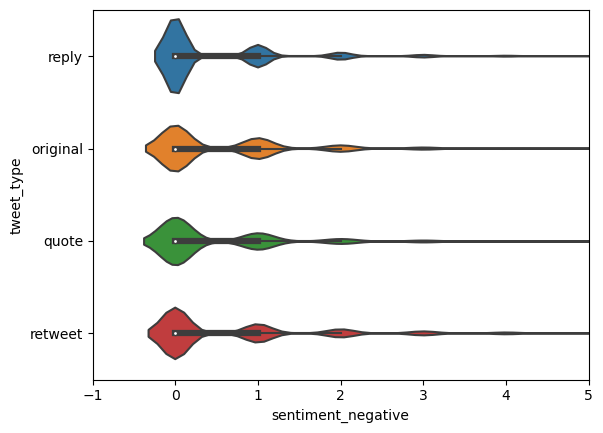

,count,mean,std,min,25%,50%,75%,max
tweet_type,,,,,,,,
original,4135.0,0.598307,0.938582,0.0,0.0,0.0,1.0,9.0
quote,1611.0,0.490999,0.840223,0.0,0.0,0.0,1.0,6.0
reply,15198.0,0.452757,0.840492,0.0,0.0,0.0,1.0,9.0
retweet,15549.0,0.701396,1.114853,0.0,0.0,0.0,1.0,10.0


,W,pval,equal_var
levene,170.722831,6.483336e-110,False


,Source,ddof1,ddof2,F,p-unc,np2
0,tweet_type,3,6333.111535,169.566472,9.747542e-106,0.013842


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,original,quote,0.5983,0.4910,0.1073,0.0255,4.2049,3256.2166,0.0002,0.1176
1,original,reply,0.5983,0.4528,0.1456,0.0161,9.0349,6056.2658,0.0000,0.1688
2,original,retweet,0.5983,0.7014,-0.1031,0.0171,-6.0227,7536.0550,0.0000,-0.0954
3,quote,reply,0.4910,0.4528,0.0382,0.0220,1.7370,1967.3100,0.3047,0.0455
4,quote,retweet,0.4910,0.7014,-0.2104,0.0228,-9.2429,2243.1871,0.0000,-0.1927
5,reply,retweet,0.4528,0.7014,-0.2486,0.0112,-22.1140,28892.3544,0.0000,-0.2514


In [15]:
# Same thing but this time for sentiment_negative
data = data.loc[data.tweet_type != "quote_reply",:]
sns.violinplot(data=data,x="sentiment_negative",y="tweet_type",alpha=0.1)
plt.xlim(-1,5)
plt.show()
display(data.loc[data.tweet_type != "quote_reply",:].groupby("tweet_type").sentiment_negative.describe())
display(pg.homoscedasticity(data=data.loc[data.tweet_type != "quote_reply",:],group="tweet_type",dv="sentiment_negative"))
display(pg.welch_anova(data=data.loc[data.tweet_type != "quote_reply",:],between="tweet_type",dv="sentiment_negative"))
display(pg.pairwise_gameshowell(data=data.loc[data.tweet_type != "quote_reply",:],between="tweet_type",dv="sentiment_negative").round(4))

# How does a tweet's motive differ between different tweet types?
* visualizing different tweet types and distribution of motive scores. 

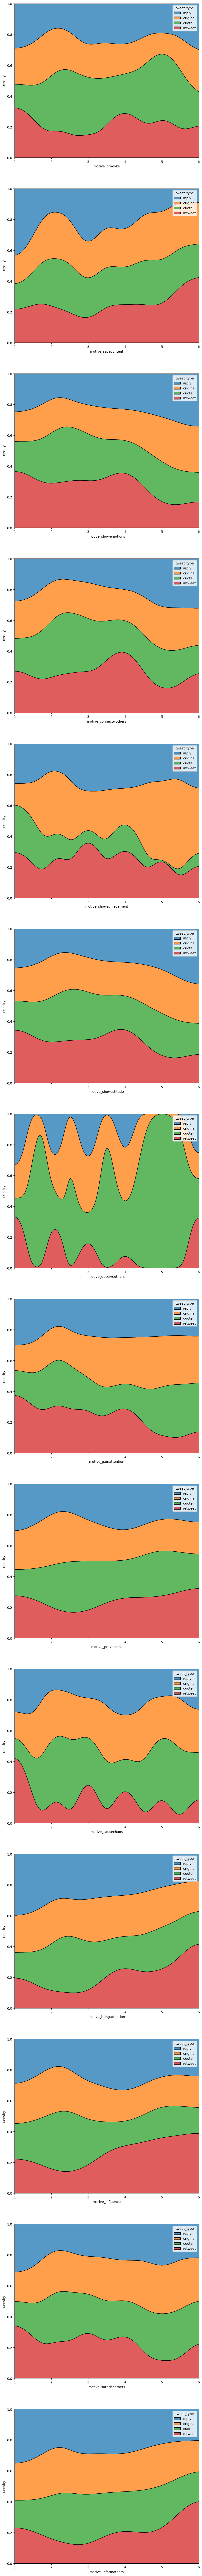

In [16]:
mots = ['motive_provoke', 'motive_savecontent', 'motive_showemotions',
       'motive_connectwothers', 'motive_showachievement',
       'motive_showattitude', 'motive_deceiveothers', 'motive_gainattention',
       'motive_provepoint', 'motive_causechaos', 'motive_bringattention',
       'motive_influence', 'motive_surpriseothers', 'motive_informothers']
fig, axs = plt.subplots(len(mots),1,figsize=(10,10*len(mots)))
for i, mot in enumerate(mots):
    sns.kdeplot(data=data, x=mot, hue="tweet_type",multiple="fill",common_norm=False,ax=axs[i])
    axs[i].set_xlim([1,6])

# Predict dominant motive as a category label using sentiment scores.
* This analysis was abandoned as I could not make it work

In [17]:
# Create dom_mot variable
data["dom_mot"] = data[mots].idxmax(axis=1).str[7:] # name of the motive with the highest score
data.loc[data[mots].max(axis=1) < 4, "dom_mot"] = np.nan # assign NaN to dom_mot whenever a tweet has less than 4 for the max motive.

In [18]:
# Create a dictionary, replace some values and make it ready for the logistic regression
mots = ['showemotions', 'informothers', 'gainattention', 'showattitude','connectwothers', 'bringattention', 'provoke', 'surpriseothers','savecontent', 'showachievement', 'provepoint', 'causechaos','influence', 'deceiveothers']
mydict = dict((val, i+1) for i, val in enumerate(mots))
#data.dom_mot =  data.dropna(subset="dom_mot").dom_mot.replace(mydict)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

sents =  ['sentiment_anger', 'sentiment_disgust', 'sentiment_fear',      'sentiment_anticipation', 'sentiment_joy', 'sentiment_sadness','sentiment_surprise', 'sentiment_trust', 'sentiment_negative','sentiment_positive']
X = data.loc[data["dom_mot"].notna(),sents]
y = data.loc[data["dom_mot"].notna(),"dom_mot"]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=3606,train_size=0.7)

lr = LogisticRegression(max_iter=200,multi_class="auto")
lr.fit(X_train,y_train)
lr.predict(X_test)
lr.score(X_test,y_test)

0.2656514382402707

# Create `users` dataframe, aggregating tweets for each users for user level analysis
* `data` was a dataframe made of individual tweets

In [20]:
# Convert 10 char length nondates into a dummy date so that you can do rest of the calculations
for i in data.index:
    if len(data.loc[i,"account_created_at"]) == 10:
        data.loc[i,"account_created_at"] = "2000-01-01 00:00:00"

from datetime import datetime

last_day = datetime.strptime("2022-06-12 23:59:59", "%Y-%m-%d %H:%M:%S") # last day in the dataset

for i in data.index: # iterate over each row
    x = datetime.strptime(data.loc[i,"account_created_at"], "%Y-%m-%d %H:%M:%S") # create a temporary variable that holds the datetime object of that row
    data.loc[i,"account_age"] = (last_day - x).days # turn the datetime object into days count and store in a new col called "account_age"


    
#  Find the rows where sentiment_xxx is >2, for these rows add a new col called is_anger and set it to True
for i_col in np.arange(52,62):
    col_name = list(data)[i_col]
    col_name_formatted = col_name[10:]
    new_col_name = "is_%s"%col_name_formatted  # string formatting: https://www.geeksforgeeks.org/string-formatting-in-python/
    data.loc[data[col_name] > 2, new_col_name] = True
    data[new_col_name] = data[new_col_name].fillna(False)
    
# Create a new dataframe called users
users = data.groupby("session").created_at.count().to_frame(name="post_count").reset_index()
users["replies_sent"] = data.groupby("session").is_reply.sum().reset_index(name="reply_count")["reply_count"]
users["retweets_sent"] = data.groupby("session").is_retweet.sum().reset_index(name="retweet_count")["retweet_count"]
users["quotes_sent"] = data.groupby("session").is_quote.sum().reset_index(name="quote_count")["quote_count"]
users.set_index("session", inplace = True)
users["quote_replies_sent"] = data.loc[(data.is_reply == 1) & (data.is_quote == 1),:].groupby("session").created_at.count()
users["quote_replies_sent"].fillna(0, inplace=True)
users["tweets_sent"] = users.post_count - users.replies_sent - users.quotes_sent - users.retweets_sent + users.quote_replies_sent
users["mean_anger"] = data.groupby("session").sentiment_anger.mean()
users["mean_disgust"] = data.groupby("session").sentiment_disgust.mean()
users["mean_fear"] = data.groupby("session").sentiment_fear.mean()
users["mean_anticipation"] = data.groupby("session").sentiment_anticipation.mean()
users["mean_joy"] = data.groupby("session").sentiment_joy.mean()
users["mean_sadness"] = data.groupby("session").sentiment_sadness.mean()
users["mean_surprise"] = data.groupby("session").sentiment_surprise.mean()
users["mean_trust"] = data.groupby("session").sentiment_trust.mean()
users["mean_negative"] = data.groupby("session").sentiment_negative.mean()
users["mean_positive"] = data.groupby("session").sentiment_positive.mean()
users["account_age_days"] = data[["account_age","session"]].replace(8198,np.nan).set_index("session").dropna().groupby("session").mean("account_age")
users["followers_count"] = data.set_index("session")["followers_count"][~data.set_index("session")["followers_count"].index.duplicated()] # number of followers a user had when they sent their first tweet

users["mean_favorite_count"] = data.loc[data.tweet_type != "retweet",["favorite_count","session"]].groupby("session").mean() # does not include RTs since they all have 0 favs. People who only sent RTs are assigned 0 to get rid of NaN
users["mean_favorite_count"].fillna(0, inplace=True) # users who only sent RTs had NaN values, they are replaced with 0
users["mean_retweet_count"] = data.loc[data.tweet_type != "retweet",["retweet_count","session"]].groupby("session").mean() # does not include RTs since they all have 0 favs.  People who only sent RTs are assigned 0 to get rid of NaN
users["mean_retweet_count"].fillna(0, inplace=True) # users who only sent RTs had NaN values, they are replaced with 0

users["popularity"] = users["mean_favorite_count"] + users["mean_retweet_count"]
users["engagement_percentage"] = users["popularity"] / users["followers_count"] * 100 # 
users["engagement_percentage"].replace(np.inf, np.nan, inplace=True) # users with zero followers now has NaN engagement score instead of inf which makes no sense
users["engagement_percentage"].fillna(0, inplace=True) # 0 follower dude got NaN. now they have 0 engagement as well
users["mean_length"] = data.groupby("session").display_text_width.mean()
#users["motive_causechaos"] = data.loc[~data.motive_causechaos.isna(),["session","motive_causechaos"]].groupby("session").mean()
#users["angry_tweets"] = data.loc[data.is_anger == 1,["session","is_anger"]].groupby("session").count()

# Create mean motive of the users' tweets
mots = ['motive_entertain', 'motive_expressopinion', 'motive_provoke', 'motive_savecontent', 'motive_showemotions', 'motive_connectwothers', 'motive_showachievement', 'motive_showattitude', 'motive_deceiveothers', 'motive_gainattention', 'motive_provepoint', 'motive_causechaos', 'motive_bringattention', 'motive_influence', 'motive_surpriseothers', 'motive_informothers']
for col in mots:
    users[col] = data.loc[~data[col].isna(),["session",col]].groupby("session").mean()

# How many tweets the person has broken down by each emotion
is_sent = ['is_anger', 'is_disgust', 'is_fear', 'is_anticipation', 'is_joy', 'is_sadness', 'is_surprise', 'is_trust','is_positive','is_negative']
count_sent =  ['count_anger', 'count_disgust', 'count_fear', 'count_anticipation', 'count_joy', 'count_sadness', 'count_surprise', 'count_trust','count_positive','count_negative']
for col in is_sent:
    users["count_" + col[3:]] = data.loc[data[col] == 1,["session",col]].groupby("session").count() # number of sentimental tweets per user
users[count_sent] = users[count_sent].fillna(0) # fill NaN values with zero

# automatize creation of new columns that show percentage of tweets that correspond to the given sentiment
pct_sent = ['pct_anger', 'pct_disgust', 'pct_fear', 'pct_anticipation', 'pct_joy', 'pct_sadness', 'pct_surprise', 'pct_trust']
for col in count_sent:
    users["pct_" + col[6:]] = users[col] / users.post_count * 100
users[pct_sent] = users[pct_sent].fillna(0) # fill NaN values with zero

# pct_highest shows how dominant the dom_sent is.
users["pct_highest"] = users[pct_sent].max(axis=1) # highest percentage is saced to a new col
users["dom_sent"] = users[pct_sent].idxmax(axis=1).str[4:] # name of the sentiment with highest percentage

# Create is_xxx cols with motive_xxx more than 3
mots = ['motive_entertain', 'motive_expressopinion', 'motive_provoke', 'motive_savecontent', 'motive_showemotions', 'motive_connectwothers', 'motive_showachievement', 'motive_showattitude', 'motive_deceiveothers', 'motive_gainattention', 'motive_provepoint', 'motive_causechaos', 'motive_bringattention', 'motive_influence', 'motive_surpriseothers', 'motive_informothers']
for col in mots:
    data.loc[data[col] > 3, "is_" + col[7:] ] = True
    data["is_" + col[7:]].fillna(False, inplace = True) # The rest will be assigned NaN. Fix it with the following code.

# Calculate count_motive for each user: number of tweets sent by the given motive.
is_mot = ['is_entertain', 'is_expressopinion', 'is_provoke', 'is_savecontent', 'is_showemotions', 'is_connectwothers', 'is_showachievement', 'is_showattitude', 'is_deceiveothers', 'is_gainattention', 'is_provepoint', 'is_causechaos', 'is_bringattention', 'is_influence', 'is_surpriseothers','is_informothers']
for col in is_mot:
    users["count_" + col[3:]] = data[is_mot + ["session"]].groupby("session").sum().loc[:,col]

# Create dom_mot variable that shows the most commonly occuring motive for each user
count_mot = ['count_entertain', 'count_expressopinion', 'count_provoke', 'count_savecontent', 'count_showemotions', 'count_connectwothers', 'count_showachievement', 'count_showattitude', 'count_deceiveothers','count_gainattention', 'count_provepoint', 'count_causechaos','count_bringattention', 'count_influence', 'count_surpriseothers','count_informothers']
users["dom_mot"] = users[count_mot].idxmax(axis=1).str[6:] # name of the sentiment with highest percentage
users.loc[users[count_mot].max(axis=1) == 0, "dom_mot"] = np.nan # assign NaN to dom_mot whenever there is no tweets with motivation info

# Calculate pct_mot that show
for col in count_mot:
    users["pct_" + col[6:]] = users[col] / users.post_count * 100
#users[pct_sent] = users[pct_sent].fillna(0) # fill NaN values with zero
pct_mot = ['pct_entertain', 'pct_expressopinion', 'pct_provoke', 'pct_savecontent', 'pct_showemotions', 'pct_connectwothers', 'pct_showachievement', 'pct_showattitude', 'pct_deceiveothers', 'pct_gainattention', 'pct_provepoint', 'pct_causechaos', 'pct_bringattention', 'pct_influence', 'pct_surpriseothers', 'pct_informothers']

# Calculate pct_positive - pct_negative
users["pct_mood"] = users.pct_positive - users.pct_negative

# Calculate pct_positive + pct_negative
users["pct_total_pos_neg"] = users.pct_positive + users.pct_negative

users["account_age_days"] = data[["account_age","session"]].replace(8198,np.nan).set_index("session").dropna().groupby("session").mean("account_age")

# assert that total number of tweets in the users table match the total number of tweets in the data table
#assert users["tweets_sent"].sum() == data.loc[(data.is_reply==0)&(data.is_retweet==0)&(data.is_quote==0),:].shape[0]
#assert users["quote_replies_sent"].sum() == data.loc[(data.is_reply==1)&(data.is_retweet==0)&(data.is_quote==1),:].shape[0]
#assert users["replies_sent"].sum() == data.loc[(data.is_reply==1),:].shape[0]
#assert users["retweets_sent"].sum() == data.loc[(data.is_retweet==1),:].shape[0]

# Subset users with more than 10 non-retweet posts

In [21]:
users.loc[:,"non_retweet_post_count"] = users.post_count - users.retweets_sent
users = users[users.non_retweet_post_count >= 10]

# Calculate percentage of nonretweet posts per user
users["pct_non_retweet"] = users.non_retweet_post_count / users.post_count * 100

users

,post_count,replies_sent,retweets_sent,quotes_sent,quote_replies_sent,tweets_sent,mean_anger,mean_disgust,mean_fear,mean_anticipation,mean_joy,mean_sadness,mean_surprise,mean_trust,mean_negative,mean_positive,account_age_days,followers_count,mean_favorite_count,mean_retweet_count,popularity,engagement_percentage,mean_length,motive_entertain,motive_expressopinion,motive_provoke,motive_savecontent,motive_showemotions,motive_connectwothers,motive_showachievement,motive_showattitude,motive_deceiveothers,motive_gainattention,motive_provepoint,motive_causechaos,motive_bringattention,motive_influence,motive_surpriseothers,motive_informothers,count_anger,count_disgust,count_fear,count_anticipation,count_joy,count_sadness,count_surprise,count_trust,count_positive,count_negative,pct_anger,pct_disgust,pct_fear,pct_anticipation,pct_joy,pct_sadness,pct_surprise,pct_trust,pct_positive,pct_negative,pct_highest,dom_sent,count_entertain,count_expressopinion,count_provoke,count_savecontent,count_showemotions,count_connectwothers,count_showachievement,count_showattitude,count_deceiveothers,count_gainattention,count_provepoint,count_causechaos,count_bringattention,count_influence,count_surpriseothers,count_informothers,dom_mot,pct_entertain,pct_expressopinion,pct_provoke,pct_savecontent,pct_showemotions,pct_connectwothers,pct_showachievement,pct_showattitude,pct_deceiveothers,pct_gainattention,pct_provepoint,pct_causechaos,pct_bringattention,pct_influence,pct_surpriseothers,pct_informothers,pct_mood,pct_total_pos_neg,non_retweet_post_count,pct_non_retweet
session,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-5wvYkXTIHpFKjb8NqRxuLM_WsyDc1YaS3HGnp6d5-VLI3Xic_kLVdS2VU8Rh9IM,22,11,10,0,0.0,1.0,0.181818,0.090909,0.136364,0.636364,0.681818,0.045455,0.545455,0.409091,0.227273,1.272727,995.0,14,95.083333,8.416667,103.500000,739.285714,87.000000,2.500000,6.000000,1.000000,1.000000,3.5000,2.500000,1.0000,3.500000,1.000000,1.000000,5.000000,1.000000,5.500000,4.000000,1.000000,2.500000,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,0.000000,0.000000,0.000000,9.090909,4.545455,0.000000,4.545455,0.000000,9.090909,0.000000,9.090909,anticipation,1,2,0,0,1,1,0,1,0,0,2,0,2,2,0,1,expressopinion,4.545455,9.090909,0.000000,0.000000,4.545455,4.545455,0.000000,4.545455,0.0,0.000000,9.090909,0.000000,9.090909,9.090909,0.000000,4.545455,9.090909,9.090909,12,54.545455
-EucvgRg40O4u2YEDClySAaRmf7LYhtZioPoZ1tX2pzzFD3zi_e7QsAfO3stQSn6,297,75,12,11,0.0,199.0,0.242424,0.090909,0.239057,0.484848,0.148148,0.104377,0.208754,0.531987,0.548822,0.333333,609.0,1389,11.003509,0.740351,11.743860,0.845490,61.498316,4.075000,2.425000,1.750000,1.850000,2.6500,2.250000,1.0000,2.450000,1.000000,1.425000,1.600000,1.450000,2.350000,1.075000,1.125000,3.075000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,4.0,4.0,1.0,0.000000,0.000000,0.336700,0.336700,0.000000,0.000000,0.336700,1.346801,1.346801,0.336700,1.346801,trust,28,14,7,9,16,14,0,14,0,5,6,5,13,1,1,18,entertain,9.427609,4.713805,2.356902,3.030303,5.387205,4.713805,0.000000,4.713805,0.0,1.683502,2.020202,1.683502,4.377104,0.336700,0.336700,6.060606,1.010101,1.683502,285,95.959596
3GlWWl37xOWffEpEK6nDkXQ5YX1ixh19dPAGq4P9umqECz9ohas4qCEb4New34q4,113,94,18,0,0.0,1.0,0.292035,0.265487,0.477876,0.495575,0.362832,0.327434,0.212389,0.690265,0.769912,0.876106,3508.0,1351,4.621053,0.231579,4.852632,0.359188,118.734513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,3.0,4.0,2.0,2.0,0.0,4.0,10.0,6.0,1.769912,1.769912,2.654867,3.539823,1.769912,1.769912,0.000000,3.539823,8.849558,5.309735,3.539823,anticipation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.539823,14.159292,95,84.070796
4SuynWm-7EjpUsyvKsSBHcLru7TaC1ru46ugK7SCAHlJhhZ_xAUA3C4jfJ97iDNY,51,12,14,12,0.0,13.0,0.411765,0.215686,0.450980,0.647059,0.529412,0.196078,0.235294,1.235294,0.490196,1.549020,3261.0,483,3.

# Testing attrition bias, i.e., comparing tweets of those who filled out the survey vs did not.
* not reported in the report due to space limitations

In [22]:
print("two sample independent t-test between for ACCOUNT AGE vals between responders and nonresponders")
display(pg.ttest(x=users.loc[users.motive_entertain.isna(),"account_age_days"],y=users.loc[users.motive_entertain.notna(),"account_age_days"]))

print("two sample independent t-test between for POST COUNT vals between responders and nonresponders")
display(pg.ttest(x=users.loc[users.motive_entertain.isna(),"post_count"],y=users.loc[users.motive_entertain.notna(),"post_count"]))

print("two sample independent t-test between for FOLLOWERS COUNT vals between responders and nonresponders")
display(pg.ttest(x=users.loc[users.motive_entertain.isna(),"followers_count"],y=users.loc[users.motive_entertain.notna(),"followers_count"]))

print("two sample independent t-test between for ENGAGEMENT PERCENTAGE vals between responders and nonresponders")
display(pg.ttest(x=users.loc[users.motive_entertain.isna(),"engagement_percentage"],y=users.loc[users.motive_entertain.notna(),"engagement_percentage"]))

print("two sample independent t-test between for MEAN LENGTH vals between responders and nonresponders")
display(pg.ttest(x=users.loc[users.motive_entertain.isna(),"mean_length"],y=users.loc[users.motive_entertain.notna(),"mean_length"]))

print("two sample independent t-test between for MEAN LENGTH vals between responders and nonresponders")
display(pg.ttest(x=users.loc[users.motive_entertain.isna(),"mean_length"],y=users.loc[users.motive_entertain.notna(),"mean_length"]))

two sample independent t-test between for ACCOUNT AGE vals between responders and nonresponders


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.088803,36.387855,two-sided,0.2834,"[-1042.38, 313.95]",0.242301,0.416,0.164533


two sample independent t-test between for POST COUNT vals between responders and nonresponders


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.221533,36.562598,two-sided,0.82591,"[-149.46, 120.01]",0.046656,0.254,0.054172


two sample independent t-test between for FOLLOWERS COUNT vals between responders and nonresponders


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.227565,20.001088,two-sided,0.233863,"[-73665.0, 284358.14]",0.62234,0.472,0.719872


two sample independent t-test between for ENGAGEMENT PERCENTAGE vals between responders and nonresponders


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.388586,88.123499,two-sided,0.168458,"[-28.39, 5.03]",0.163115,0.565,0.102223


two sample independent t-test between for MEAN LENGTH vals between responders and nonresponders


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.53211,22.916367,two-sided,0.599771,"[-19.04, 32.22]",0.183148,0.281,0.116191


two sample independent t-test between for MEAN LENGTH vals between responders and nonresponders


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.53211,22.916367,two-sided,0.599771,"[-19.04, 32.22]",0.183148,0.281,0.116191


# Some scatterplots to explore `users` by the following variables: followers_count, account_age, number_of_tweets, ratio of original tweets

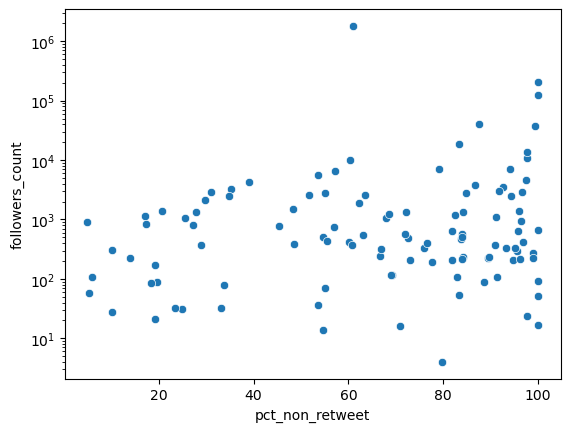

In [23]:
sns.scatterplot(data=users,y="followers_count",x="pct_non_retweet")
plt.yscale("log")

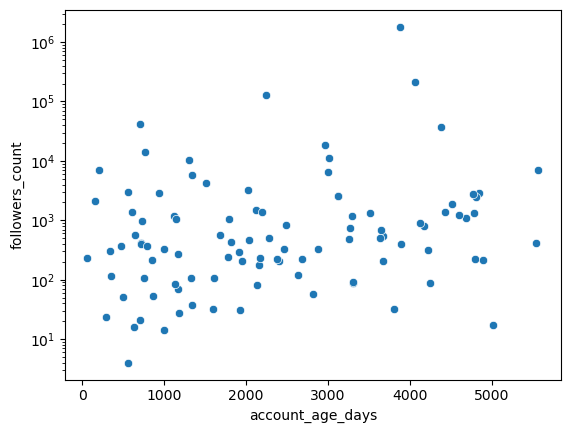

In [24]:
sns.scatterplot(data=users,x="account_age_days",y="followers_count")
plt.yscale("log")

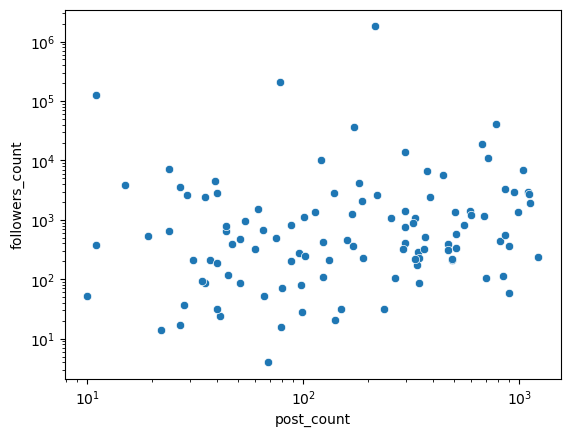

In [25]:
sns.scatterplot(data=users,x="post_count",y="followers_count")
plt.yscale("log")
plt.xscale("log")

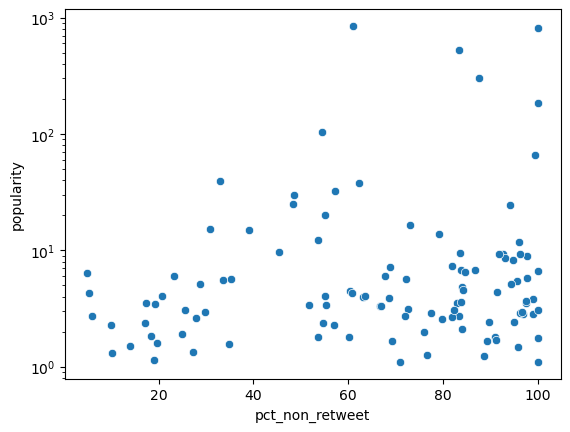

In [26]:
sns.scatterplot(data=users,y="popularity",x="pct_non_retweet")
plt.yscale("log")

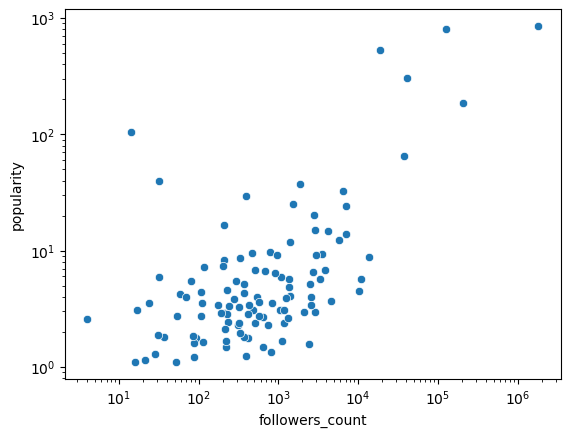

In [27]:
sns.scatterplot(data=users,x="followers_count",y="popularity")
plt.xscale("log")
plt.yscale("log")

# Clustering users based on followers_count, account_age, number_of_tweets, ratio of original tweets, mean_tweet_length

In [28]:
def optimize_kmeans(data, max_k): # Create a function that applies k-means clustering with increasingly many clusters and plits an elbow plot.
    """Applies k-means clustering to data for 1 cluster  upto max_k clusters. Draws an elbow plot for you to 
    manually determine the appropriate number of clusters. The point that corresponds to the elbow is the right
    amount of cluster you should have"""

    n_k = []
    inertias = []
    
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)
        n_k.append(k)
        inertias.append(kmeans.inertia_)
     
    # elbow plot
    fig = plt.subplots(figsize=(15,5))
    plt.plot(n_k,inertias,"o-")
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show

In [29]:
feats = ["followers_count","account_age_days","post_count","pct_non_retweet","popularity","mean_length"] # features I would like to use for my clustering
from sklearn.preprocessing import StandardScaler

# using standard scaler to prepare features for the clustering.
scaler = StandardScaler() 
feats_t = []
for feat in feats:
    feats_t.append(feat + "_t")
    
users[feats_t] = scaler.fit_transform(users[feats])

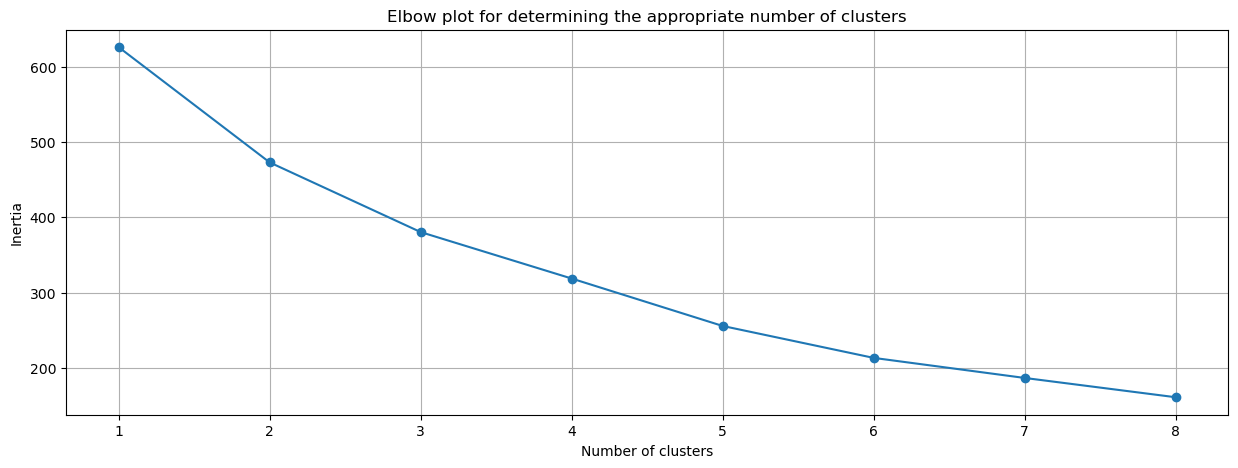

In [30]:
optimize_kmeans(users[feats_t].dropna(),8)
_=plt.title("Elbow plot for determining the appropriate number of clusters")
plt.savefig("/Users/ekinderdiyok/Documents/MPI/Twitter/Visualizations/elbow.png",dpi=300)

# Clustering using t-SNE this time.

/Users/ekinderdiyok/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


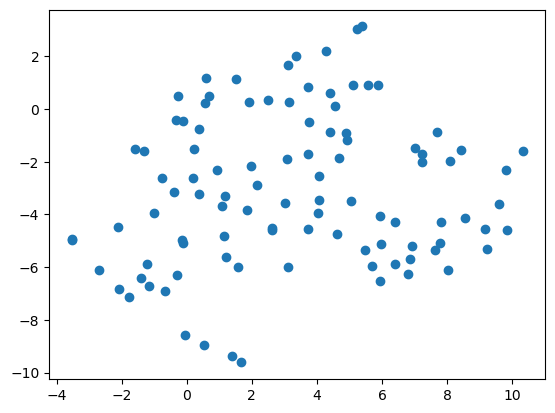

In [31]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate=100)
transformed = model.fit_transform(users[feats_t].dropna())
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs, ys)
plt.show()


# Bartlett test comparing variances

In [32]:
from scipy.stats import bartlett
stats = []
ps = []
for mot in mots:
    OPs = data.loc[data.tweet_type == "original",mot]
    reps_rets = data.loc[data.tweet_type == "retweet",mot]
    stat, p = bartlett(OPs, reps_rets)
    stats.append(stat)
    ps.append(p)
my_bartlett = pd.DataFrame(list([mots, stats, ps])).T
pd.options.display.float_format = '{:,.4f}'.format
my_bartlett = my_bartlett.rename(columns={0:"motive",1:"test statistics",2:"p-values"})
my_bartlett.set_index("motive")
my_bartlett.to_csv("/Users/ekinderdiyok/Documents/MPI/Twitter/my_bartlett_v02.csv")

In [33]:
display(data.loc[data.tweet_type=="original",mots].describe().loc["std"])
display(data.loc[data.tweet_type=="retweet",mots].describe().loc["std"])

motive_entertain         1.9345
motive_expressopinion    2.1189
motive_provoke           1.5531
motive_savecontent       2.0513
motive_showemotions      2.0640
motive_connectwothers    1.8852
motive_showachievement   1.7569
motive_showattitude      2.0541
motive_deceiveothers     0.6701
motive_gainattention     1.8671
motive_provepoint        1.9887
motive_causechaos        1.5931
motive_bringattention    2.0302
motive_influence         1.9601
motive_surpriseothers    1.8307
motive_informothers      2.0619
Name: std, dtype: float64

motive_entertain         1.9704
motive_expressopinion    1.9354
motive_provoke           1.4958
motive_savecontent       2.1537
motive_showemotions      1.8291
motive_connectwothers    1.6760
motive_showachievement   1.2640
motive_showattitude      1.8481
motive_deceiveothers     0.6099
motive_gainattention     1.5648
motive_provepoint        2.0934
motive_causechaos        1.0351
motive_bringattention    1.7961
motive_influence         2.0639
motive_surpriseothers    1.5386
motive_informothers      1.9942
Name: std, dtype: float64

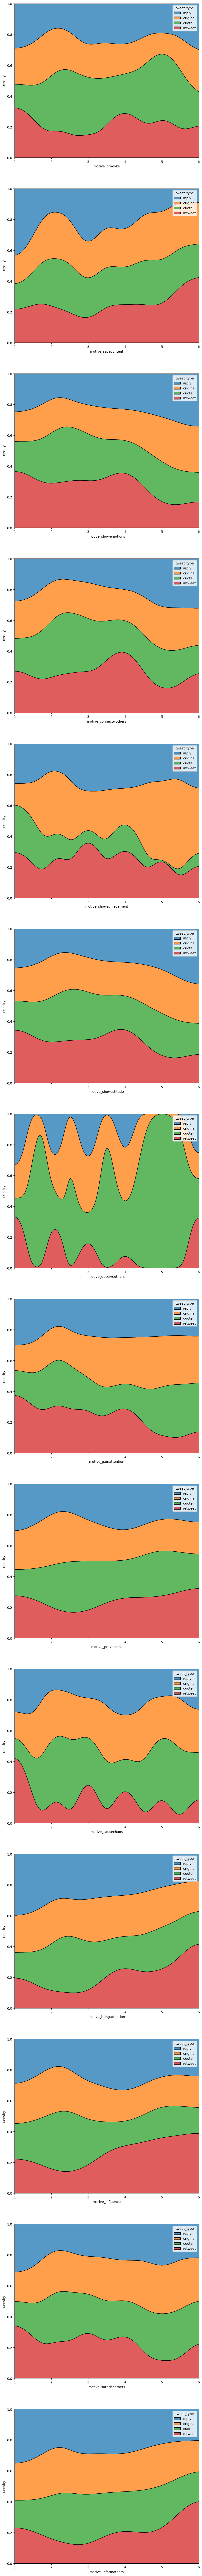

In [34]:

mots = ['motive_provoke', 'motive_savecontent', 'motive_showemotions',
       'motive_connectwothers', 'motive_showachievement',
       'motive_showattitude', 'motive_deceiveothers', 'motive_gainattention',
       'motive_provepoint', 'motive_causechaos', 'motive_bringattention',
       'motive_influence', 'motive_surpriseothers', 'motive_informothers']
fig, axs = plt.subplots(len(mots),1,figsize=(10,10*len(mots)))
for i, mot in enumerate(mots):
    sns.kdeplot(data=data, x=mot, hue="tweet_type",multiple="fill",common_norm=False,ax=axs[i])
    axs[i].set_xlim([1,6])

In [35]:
data.groupby("tweet_type")[mots].describe()

motive_provoke                                                   \
                    count   mean    std    min    25%    50%    75%    max   
tweet_type                                                                   
original         197.0000 1.8376 1.5531 1.0000 1.0000 1.0000 2.0000 6.0000   
quote             74.0000 2.2027 1.6633 1.0000 1.0000 1.0000 4.0000 6.0000   
reply            786.0000 1.9211 1.5806 1.0000 1.0000 1.0000 3.0000 6.0000   
retweet          907.0000 1.8346 1.4958 1.0000 1.0000 1.0000 2.0000 6.0000   

           motive_savecontent                                            \
                        count   mean    std    min    25%    50%    75%   
tweet_type                                                                
original             197.0000 2.7310 2.0513 1.0000 1.0000 1.0000 5.0000   
quote                 74.0000 2.5811 2.0541 1.0000 1.0000 1.0000 4.0000   
reply                786.0000 1.8562 1.4659 1.0000 1.0000 1.0000 3.0000   
retweet              907.0000 2.9460 2.1537 1.0000 1.0000 2.0000 6.0000   

                  motive_showemotions                                     \
              max               count   mean    std    min    25%    50%   
tweet_type                                                                 
original   6.0000            197.0000 4.0051 2.0640 1.0000 1.0000 4.0000   
quote      6.0000             74.0000 3.5541 2.0416 1.0000 1.0000 4.0000   
reply      6.0000            786.0000 3.9275 2.0003 1.0000 1.0000 4.0000   
retweet    6.0000            907.0000 3.1279 1.8291 1.0000 1.0000 4.0000   

                         motive_connectwothers                              \
              75%    max                 count   mean    std    min    25%   
tweet_type                                                                   
original   6.0000 6.0000              197.0000 4.0457 1.8852 1.0000 3.0000   
quote      6.0000 6.0000               74.0000 3.8649 1.8604 1.0000 2.2500   
reply      6.0000 6.0000              786.0000 4.2455 1.8247 1.0000 4.0000   
retweet    4.0000 6.0000              907.0000 3.9405 1.6760 1.0000 3.0000   

                                motive_showachievement                       \
              50%    75%    max                  count   mean    std    min   
tweet_type                                                                    
original   4.0000 6.0000 6.0000               197.0000 2.0711 1.7569 1.0000   
quote      4.0000 6.0000 6.0000                74.0000 1.2568 0.8610 1.0000   
reply      5.0000 6.0000 6.0000               786.0000 1.6934 1.4030 1.0000   
retweet    4.0000 5.0000 6.0000               907.0000 1.6108 1.2640 1.0000   

                                       motive_showattitude                \
              25%    50%    75%    max               count   mean    std   
tweet_type                                                                 
original   1.0000 1.0000 3.0000 6.0000            197.0000 3.5381 2.0541   
quote      1.0000 1.0000 1.0000 6.0000             74.0000 3.3919 2.0260   
reply      1.0000 1.0000 1.0000 6.0000            786.0000 3.7150 2.0751   
retweet    1.0000 1.0000 1.0000 6.0000            907.0000 3.0540 1.8481   

                                              motive_deceiveothers         \
              min    25%    50%    75%    max                count   mean   
tweet_type                                                                  
original   1.0000 1.0000 4.0000 6.0000 6.0000             197.0000 1.1421   
quote      1.0000 1.0000 4.0000 5.0000 6.0000              74.0000 1.2432   
reply      1.0000 1.0000 4.0000 6.0000 6.0000             786.0000 1.0980   
retweet    1.0000 1.0000 3.0000 4.0000 6.0000             907.0000 1.0937   

                                                     motive_gainattention  \
              std    min    25%    50%    75%    max                count   
tweet_type                                                                  


data_rt_ori = data.loc[data.tweet_type.isin(["retweet","original"])]
data_rt_ori.tweet_type.value_counts()
data_rt_sampled = data.loc[data.tweet_type == "retweet"].sample(4135)
data_ori = data.loc[data.tweet_type == "original"]
data_ori.tweet_type.value_counts()
data_ori_rt_sampled = pd.concat([data_ori, data_rt_sampled], axis=1)
data_ori_rt_sampled

In [36]:
data.tweet_type.value_counts()
data_rt_sampled = data.loc[data.tweet_type == "retweet",:].sample(4135)
data_og = data.loc[data.tweet_type == "original",:]
data_rt_og = pd.concat([data_og,data_rt_sampled])

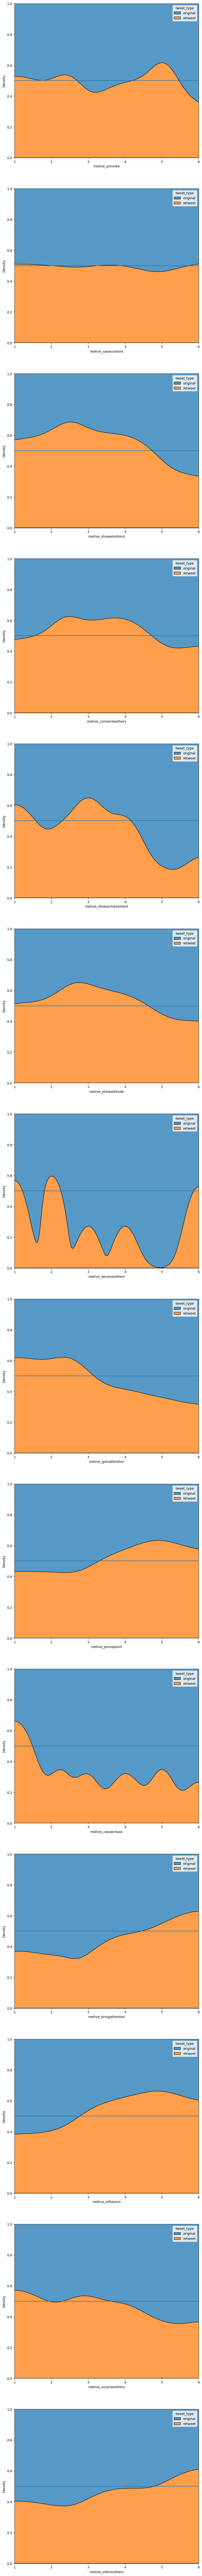

In [37]:
mots = ['motive_provoke', 'motive_savecontent', 'motive_showemotions',
       'motive_connectwothers', 'motive_showachievement',
       'motive_showattitude', 'motive_deceiveothers', 'motive_gainattention',
       'motive_provepoint', 'motive_causechaos', 'motive_bringattention',
       'motive_influence', 'motive_surpriseothers', 'motive_informothers']
fig, axs = plt.subplots(len(mots),1,figsize=(10,10*len(mots)))
for i, mot in enumerate(mots):
    sns.kdeplot(data=data_rt_og, x=mot, hue="tweet_type",multiple="fill",common_norm=False,ax=axs[i])
    axs[i].set_xlim([1,6])
    axs[i].axhline(y=0.5)

In [38]:
stats = []
ps = []
std_rt = []
std_op = []
mean_rt = []
mean_op = []

for mot in mots:
    OPs = data.loc[data.tweet_type == "original",mot]
    rts = data.loc[data.tweet_type == "retweet",mot]
    #reps_rets = data.loc[data.tweet_type.isin(["reply" or "retweet"]),mot]
    stat, p = bartlett(OPs, rts)
    stats.append(stat)
    ps.append(p)
    std_op.append(data.loc[data.tweet_type=="original",mot].std())
    std_rt.append(data.loc[data.tweet_type=="retweet",mot].std())
    #mean_op.append(OPs.mean())
    #mean_rt.append(rts.mean())

difference = (pd.Series(std_op) - pd.Series(std_rt))/pd.Series(std_rt)*100
my_bartlett = pd.DataFrame(list([mots, stats, ps,std_op,std_rt,difference])).T
pd.options.display.float_format = '{:,.4f}'.format
my_bartlett = my_bartlett.rename(columns={0:"motive",1:"test statistics",2:"p-values",3:"Original post SD",4:"Retweet SD",5:"Percentage difference SD"})
my_bartlett.set_index("motive")
my_bartlett.to_csv("/Users/ekinderdiyok/Documents/MPI/Twitter/my_bartlett_v03.csv")
my_bartlett

,motive,test statistics,p-values,Original post SD,Retweet SD,Percentage difference SD
0,motive_provoke,9.3657,0.0022,1.5531,1.4958,3.8313
1,motive_savecontent,15.1994,0.0001,2.0513,2.1537,-4.7536
2,motive_showemotions,99.7823,0.0000,2.0640,1.8291,12.8426
3,motive_connectwothers,94.5137,0.0000,1.8852,1.6760,12.4861
4,motive_showachievement,796.0303,0.0000,1.7569,1.2640,38.9918
5,motive_showattitude,75.9069,0.0000,2.0541,1.8481,11.1462
6,motive_deceiveothers,60.0000,0.0000,0.6701,0.6099,9.8729
7,motive_gainattention,217.5982,0.0000,1.8671,1.5648,19.3197
8,motive_provepoint,16.8561,0.0000,1.9887,2.0934,-5.0020
9,motive_causechaos,"1,408.0696",0.0000,1.5931,1.0351,53.8993


# Boxplot to visualize negativity bias
* I decided to report the violin plot and abandoned this plot

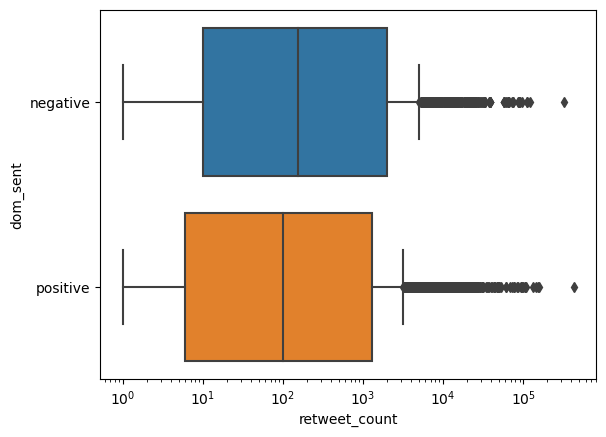

In [39]:
x1 = data.loc[(data.dom_sent == "negative") & (data.retweet_count > 0),["retweet_count","dom_sent"]]
x2 = data.loc[(data.dom_sent == "positive") & (data.retweet_count > 0),["retweet_count","dom_sent"]]
xs = pd.concat([x1,x2])
sns.boxplot(data=xs,x="retweet_count",y="dom_sent")
plt.xscale("log")

# Violinplot to visualize negativity bias

Text(0, 0.5, 'Sentiment of the tweet')

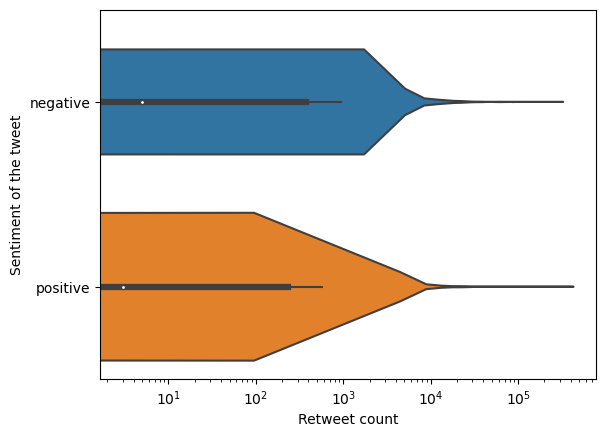

In [40]:
x1 = data.loc[(data.dom_sent == "negative"),["retweet_count","dom_sent"]]
x2 = data.loc[(data.dom_sent == "positive"),["retweet_count","dom_sent"]]
xs = pd.concat([x1,x2])
sns.violinplot(data=xs,x="retweet_count",y="dom_sent",scale="area")
plt.xscale("log")
#plt.xlim([1,100000])
plt.xlabel("Retweet count")
plt.ylabel("Sentiment of the tweet")

Text(0.5, 0, 'Retweet count')

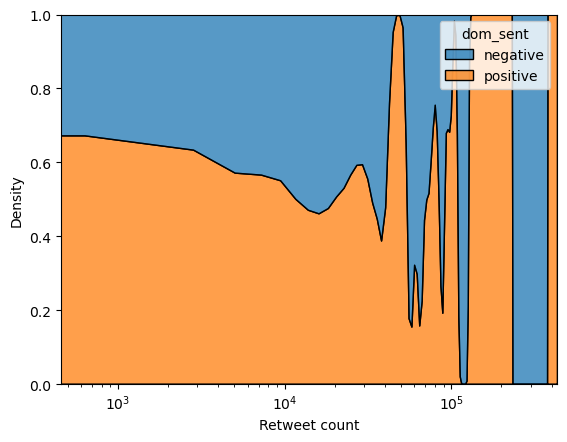

In [60]:
x1 = data.loc[(data.dom_sent == "negative"),["retweet_count","dom_sent"]]
x2 = data.loc[(data.dom_sent == "positive"),["retweet_count","dom_sent"]]
xs = pd.concat([x1,x2])
#sns.kdeplot(x=x1.retweet_count)
sns.kdeplot(data=xs, x="retweet_count",hue="dom_sent",multiple="fill")
plt.xscale("log")
#plt.xlim([1,100000])
plt.xlabel("Retweet count")
#plt.ylabel("Sentiment of the tweet")

# ECDF plot to visualize negativity bias
* I decided to report the violin plot and abandoned this plot

(0.98, 1.0)

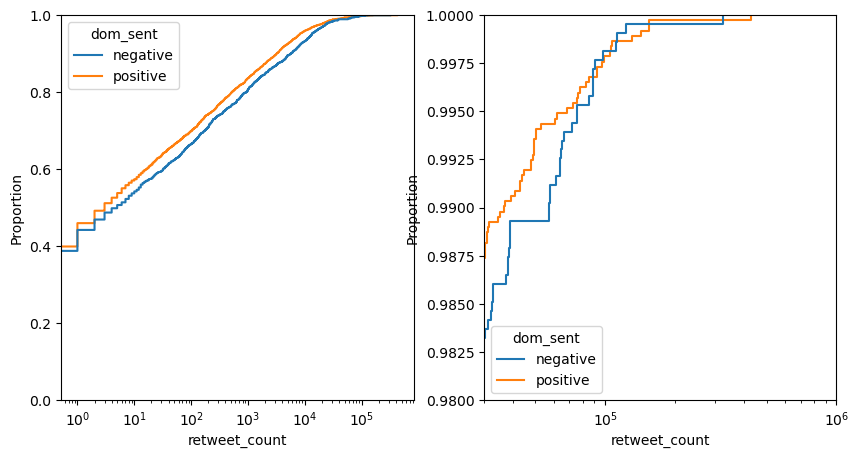

In [41]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
sns.ecdfplot(data=xs, x="retweet_count", hue="dom_sent",ax=axs[0])
axs[0].set_xscale("log")
#plt.xlim([30000,1000000])
#plt.ylim([0.9,1])

sns.ecdfplot(data=xs, x="retweet_count", hue="dom_sent",ax=axs[1])
plt.xscale("log")
plt.xlim([30000,1000000])
plt.ylim([0.98,1])

# Linear regression to explain a single motive with multiple sentiments

In [42]:
X = data.dropna(subset="motive_entertain")[sents]
y = data['motive_showemotions'].dropna()
lm = pg.linear_regression(X, y)
lm

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.3551,0.0560,59.9421,0.0000,0.0263,0.0216,3.2454,3.4649
1,sentiment_anger,-0.0394,0.1135,-0.3475,0.7283,0.0263,0.0216,-0.2620,0.1831
2,sentiment_disgust,0.2310,0.1128,2.0485,0.0406,0.0263,0.0216,0.0099,0.4522
3,sentiment_fear,-0.0464,0.1001,-0.4632,0.6433,0.0263,0.0216,-0.2426,0.1499
4,sentiment_anticipation,0.3353,0.0793,4.2302,0.0000,0.0263,0.0216,0.1799,0.4908
5,sentiment_joy,0.0882,0.1063,0.8299,0.4067,0.0263,0.0216,-0.1202,0.2966
6,sentiment_sadness,-0.1714,0.1001,-1.7120,0.0870,0.0263,0.0216,-0.3677,0.0249
7,sentiment_surprise,-0.1333,0.1075,-1.2393,0.2154,0.0263,0.0216,-0.3441,0.0776
8,sentiment_trust,-0.0945,0.0774,-1.2220,0.2218,0.0263,0.0216,-0.2463,0.0572
9,sentiment_negative,0.1241,0.0787,1.5762,0.1151,0.0263,0.0216,-0.0303,0.2785


In [43]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36593 entries, 2 to 48418
Data columns (total 102 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    created_at                      object 
 1    is_quote                        bool   
 2    is_retweet                      bool   
 3    is_reply                        object 
 4    display_text_width              int64  
 5    favorite_count                  int64  
 6    retweet_count                   int64  
 7    quote_count                     float64
 8    reply_count                     float64
 9    hashtags                        object 
 10   media_type                      float64
 11   quoted_favorite_count           float64
 12   quoted_retweet_count            float64
 13   retweet_favorite_count          float64
 14   retweet_retweet_count           float64
 15   retweet_verified                object 
 16   followers_count                 int64  
 17   friends_co

In [44]:
sent_n = []
for sent in sents:
    sent_n.append(sent + "_n")

for sent in sents:
    
    test[sent_n] = data[sent] / data.display_text_width

NameError: name 'test' is not defined

In [ ]:
test = data[sent] / data.display_text_width

In [8]:
data[sents].describe()

,sentiment_anger,sentiment_disgust,sentiment_fear,sentiment_anticipation,sentiment_joy,sentiment_sadness,sentiment_surprise,sentiment_trust,sentiment_negative,sentiment_positive
count,48419.000000,48419.00000,48419.000000,48419.000000,48419.000000,48419.000000,48419.000000,48419.000000,48419.000000,48419.000000
mean,0.263595,0.18848,0.313534,0.402032,0.351143,0.264276,0.197030,0.486214,0.543051,0.777463
std,0.598798,0.48361,0.680558,0.727308,0.678835,0.597272,0.479286,0.828610,0.953231,1.123054
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,7.000000,6.00000,8.000000,7.000000,8.000000,7.000000,6.000000,9.000000,10.000000,10.000000
